# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## +0.2 балла к домашке от Darky Dash

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

##### Put your markdown formulas here

Как мы можем понять, что градиент будет просто сумма градиентов? Регуляризация ВСЕГДА просто прибавляется, поэтому логично выходит вывод из моего риторического вопроса.

Теперь можно посчитать градиент потерь по w для наших регуляризаций - для $|w_i|  gamma$ это будет $sign(w_i) \cdot \gamma$

Логично, что после этого модули суммируются, и тогда производная суммы это сумма производных(на матане такое было и подробно рассказывали).

Следовательно, тогда в векторном виде $$\frac{d L}{d w} ( ||w||  \gamma ) = sign(w) \cdot \gamma$$

Для квадрата вместо модуля, будет не $sign$, а умножение на $2$(по аналогии):

$$\frac{d L}{d w} (||w|| ^ 2  \beta) = 2 w  \beta $$

Распишем сигмоиду:

$$\sigma{(w^\top x_i)} = \frac{1}{1 + \exp(-w^\top x_i)}$$

Теперь найдем градиент для $w$ сразу в векторном виде:


$$\frac{d L}{d w} (\sum_{i=1}^{N} -y_i \ln{\sigma{(w^\top x_i)}} - (1 - y_i) \ln{(1 - \sigma{(w^\top x_i)})}) = $$

$$ = \sum_{i=1}^{N} -y_i \frac{1}{\sigma{(w^\top x_i)}} \sigma{(w^\top x_i)} (1 - \sigma{(w^\top x_i)})x_i - (1-y_i)\frac{1}{ 1 - \sigma{(w^\top x_i)}} \sigma{(w^\top x_i)} (1 - \sigma{(w^\top x_i)})(-x_i) = $$

$$ = \sum_{i=1}^{N} -y_i (1 - \sigma{(w^\top x_i)})x_i + x_i (1-y_i) \sigma{(w^\top x_i)} = $$

$$ = \sum_{i=1}^{N} -y_i x_i + \sigma{(w^\top x_i)} x_i y_i + x_i \sigma{(w^\top x_i)} - y_i x_i \sigma{(w^\top x_i)} = $$

$$ = \sum_{i=1}^{N} x_i \sigma{(w^\top x_i)} - y_i x_i$$


Теперь соберем робота:

$$ \nabla L(w, w_0) = \sum_{i=1}^{N} x_i \sigma{(w^\top x_i)} - y_i x_i  + sign(w) \cdot \gamma + 2 w \beta = \sum_{i=1}^{N} x_i (\sigma{(w^\top x_i)} - y_i)  + sign(w) \cdot \gamma + 2 w \beta$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [3]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    sigmoid = 1 / (1 + np.exp(-np.dot(X, w)))
    log_loss = np.sum(y * np.log(sigmoid) + (1 - y) * np.log(1 - sigmoid))
    l1_penalty = gamma * np.sum(np.abs(w))
    l2_penalty = 2 * beta * np.sum(w**2)
    total_loss = -log_loss + l1_penalty + l2_penalty
    return total_loss

#### 3. [0.25 points] Implement the gradient (as a function)

In [4]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> List[float]:
    sigmoid = 1 / (1 + np.exp(-np.dot(X, w)))
    gradient_log_loss = np.dot(X.T, (sigmoid - y))
    gradient_l1_penalty = gamma * np.sign(w)
    gradient_l2_penalty = 2 * beta * w
    total_gradient = gradient_log_loss + gradient_l1_penalty + gradient_l2_penalty
    return total_gradient

#### Check yourself

In [5]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
display(grad_w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

array([-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487,
       -5.21496336])

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [7]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        # you may additional properties if you wish
        self.loss_history = []  # saving the loss on each iteration
        self.w_history = []  # дебаг через вектор весов

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        np.random.seed(self.random_state)
        N, p = X.shape
        self.w = np.random.randn(p)  # веса рандомными значениями заполним
        prev_loss = float('inf')

        for iter in range(self.max_iter):
            gradient, current_loss = self.find_gradient(X, y)
            self.w -= self.lr * gradient
            self.loss_history.append(current_loss)
            self.w_history.append(self.w.copy())

            if abs(prev_loss - current_loss) < self.tolerance:
                break
            prev_loss = current_loss

        return self

    def find_gradient(self, X, y):
        # взято из задания выше
        sigmoid = 1 / (1 + np.exp(-np.dot(X, self.w)))
        gradient_log_loss = np.dot(X.T, (sigmoid - y))
        gradient_l1_penalty = self.gamma * np.sign(self.w)
        gradient_l2_penalty = 2 * self.beta * self.w
        total_gradient = gradient_log_loss + gradient_l1_penalty + gradient_l2_penalty
        return total_gradient, self.loss(X, y, self.w, self.gamma, self.beta)

    def loss(self, X, y, w, gamma, beta):
        # взято из задания выше
        sigmoid = 1 / (1 + np.exp(-np.dot(X, w)))
        log_loss = np.sum(y * np.log(sigmoid) + (1 - y) * np.log(1 - sigmoid))
        l1_penalty = gamma * np.sum(np.abs(w))
        l2_penalty = 2 * beta * np.sum(w**2)
        total_loss = -log_loss + l1_penalty + l2_penalty
        return total_loss

    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        # your code here
        sigmoid = 1 / (1 + np.exp(-np.dot(X, self.w)))
        return (sigmoid >= 0.5).astype(int)

    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        return np.array([1 / (1 + np.exp(np.dot(X, self.w))),\
                         1 / (1 + np.exp(-np.dot(X, self.w)))])

In [8]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [9]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

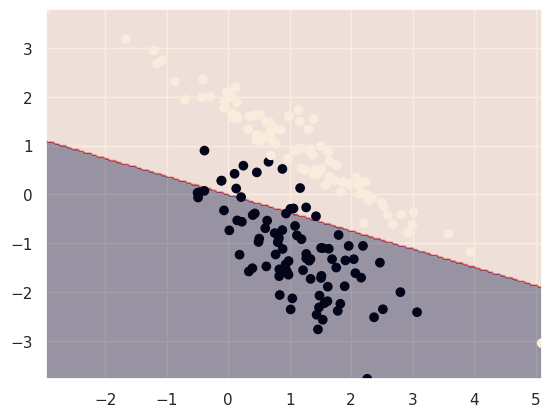

In [10]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps


Классно, оно даже сошлось, я рад
Но с каждым разом задания все труднее и веселее

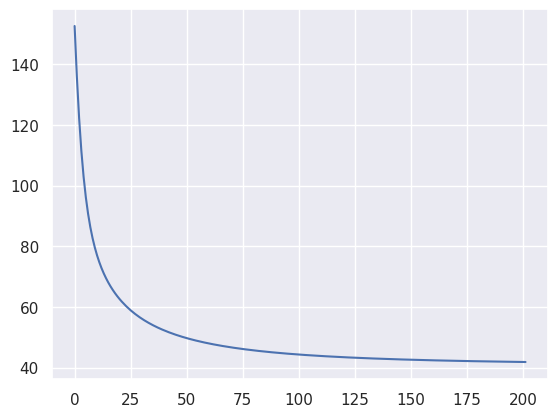

In [11]:
# your code here
plt.plot(model.loss_history)

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [12]:
# your code here
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score


# для полиномиальной функции ядра попробуем разные степени изучить. с помощью
# параметра degree

linsvc_model = SVC(kernel='linear')
rbfsvc_model = SVC(kernel='rbf')
polysvc_model_deg4 = SVC(kernel='poly', degree=4)
polysvc_model_deg5 = SVC(kernel='poly', degree=5)
polysvc_model_deg6 = SVC(kernel='poly', degree=6)

# random_state в 42 как на семах делали
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)
linsvc_model.fit(X_train, y_train)
rbfsvc_model.fit(X_train, y_train)
polysvc_model_deg4.fit(X_train, y_train)
polysvc_model_deg5.fit(X_train, y_train)
polysvc_model_deg6.fit(X_train, y_train)

pd.DataFrame([\
[f1_score(linsvc_model.predict(X_test), y_test), roc_auc_score(linsvc_model.predict(X_test), y_test), accuracy_score(linsvc_model.predict(X_test), y_test)],\
[f1_score(rbfsvc_model.predict(X_test), y_test), roc_auc_score(rbfsvc_model.predict(X_test), y_test), accuracy_score(rbfsvc_model.predict(X_test), y_test)],\
[f1_score(polysvc_model_deg4.predict(X_test), y_test), roc_auc_score(polysvc_model_deg4.predict(X_test), y_test), accuracy_score(polysvc_model_deg4.predict(X_test), y_test)],\
[f1_score(polysvc_model_deg5.predict(X_test), y_test), roc_auc_score(polysvc_model_deg5.predict(X_test), y_test), accuracy_score(polysvc_model_deg5.predict(X_test), y_test)],\
[f1_score(polysvc_model_deg6.predict(X_test), y_test), roc_auc_score(polysvc_model_deg6.predict(X_test), y_test), accuracy_score(polysvc_model_deg6.predict(X_test), y_test)]],\
columns = ['f1', 'roc_auc', 'accuracy'], index=['linear', 'rbf', 'poly_4', 'poly_5', 'poly_6'])

,f1,roc_auc,accuracy
linear,1.000000,1.000000,1.000000
rbf,1.000000,1.000000,1.000000
poly_4,0.897959,0.921875,0.907407
poly_5,0.941176,0.950000,0.944444
poly_6,0.800000,0.875000,0.833333


Как сказал Darky Dash, модель переобучилась в случае linear и rbf

И на нем 1? Прикольно чё)) Ну пусть будет, хз что там

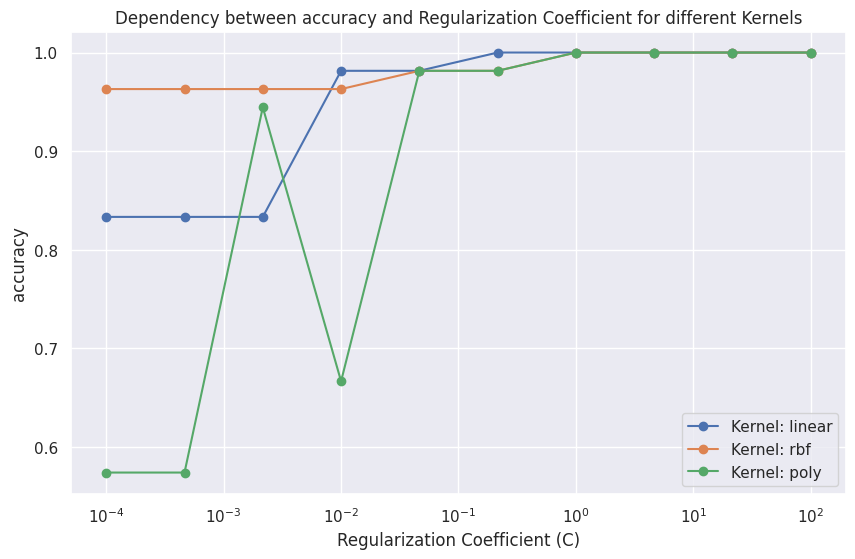

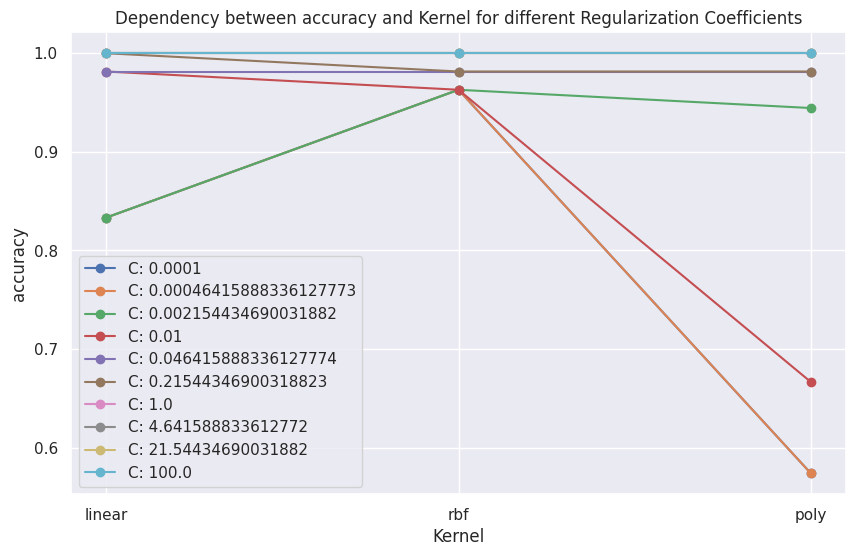

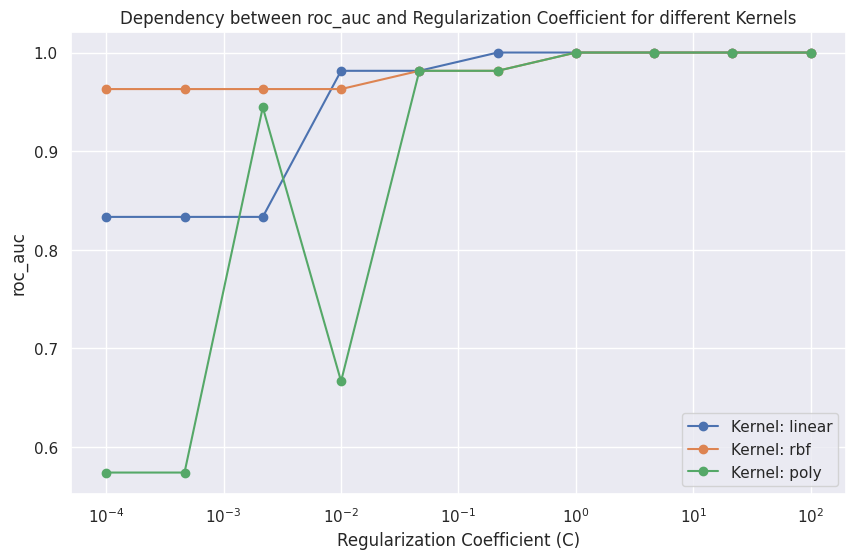

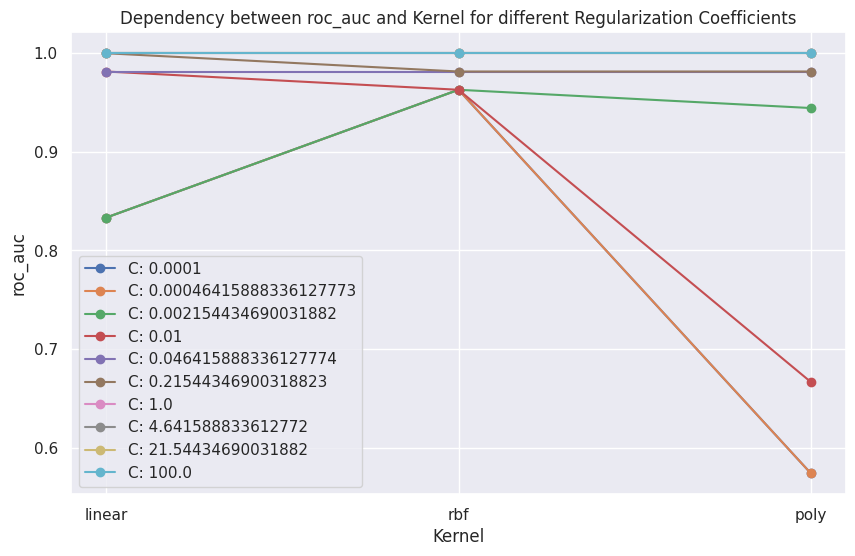

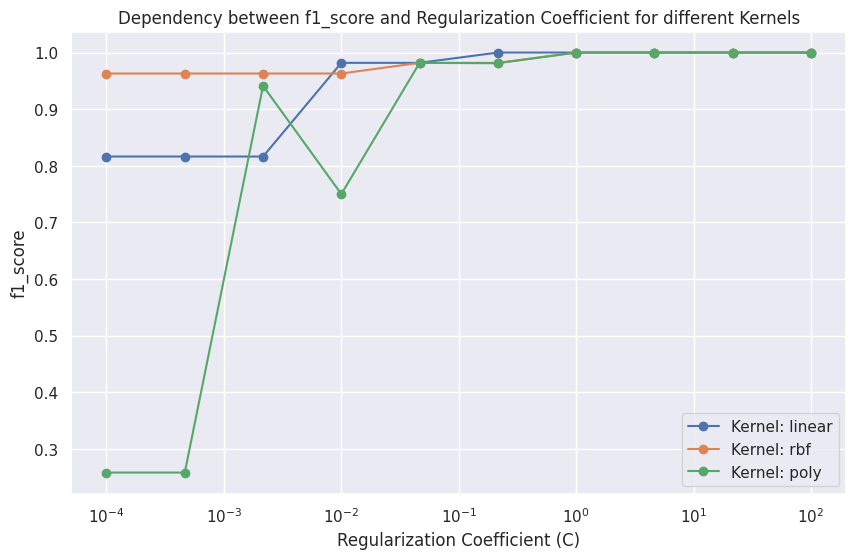

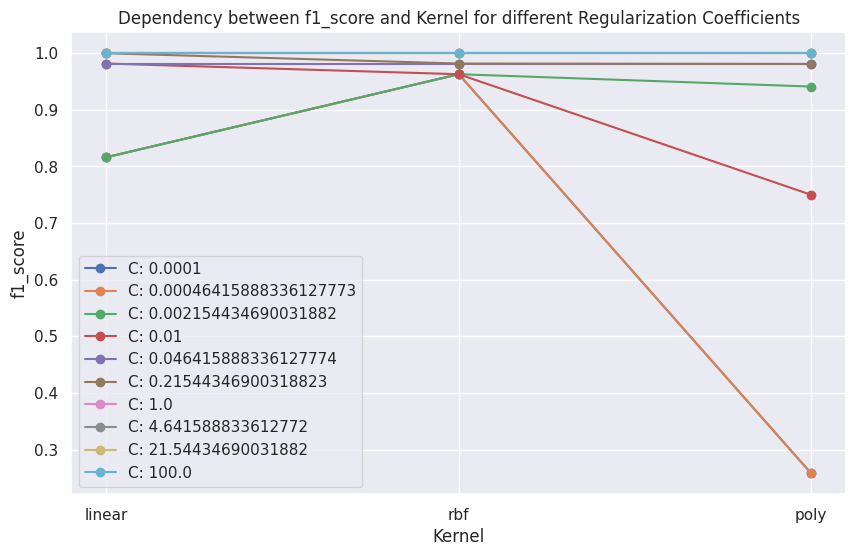

In [13]:
from sklearn.datasets import make_classification

# Define the parameters to explore
kernels = ['linear', 'rbf', 'poly']
C_values = np.logspace(-4, 2, 10)
# Initialize lists to store results
kernel_results = {kernel: {'accuracy': [], 'roc_auc': [], 'f1_score': []} for kernel in kernels}
C_results = {C: {'accuracy': [], 'roc_auc': [], 'f1_score': []} for C in C_values}

# Try different kernels and regularization coefficients
for kernel in kernels:
    for C in C_values:
        # Train the SVM classifier
        clf = SVC(kernel=kernel, C=C)
        clf.fit(X_train, y_train)

        # Make predictions
        y_pred = clf.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results
        kernel_results[kernel]['accuracy'].append(accuracy)
        kernel_results[kernel]['roc_auc'].append(roc_auc)
        kernel_results[kernel]['f1_score'].append(f1)

        C_results[C]['accuracy'].append(accuracy)
        C_results[C]['roc_auc'].append(roc_auc)
        C_results[C]['f1_score'].append(f1)

# Plot the dependencies between metrics and parameters
for metric in ['accuracy', 'roc_auc', 'f1_score']:
    plt.figure(figsize=(10, 6))
    for kernel in kernels:
        plt.plot(C_values, kernel_results[kernel][metric], marker='o', label=f'Kernel: {kernel}')
    plt.xlabel('Regularization Coefficient (C)')
    plt.ylabel(metric)
    plt.xscale('log')
    plt.legend()
    plt.title(f'Dependency between {metric} and Regularization Coefficient for different Kernels')
    plt.show()

    plt.figure(figsize=(10, 6))
    for C in C_values:
        plt.plot(kernels, C_results[C][metric], marker='o', label=f'C: {C}')
    plt.xlabel('Kernel')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'Dependency between {metric} and Kernel for different Regularization Coefficients')
    plt.show()

Выводы исходя из графиков выше:


Лучший C - это 100 поскольку там выходит уже в линию параллельную оси kernel

linear сильнее всех переобучается, но также заметны скачки в poly особенно и в частности rbf

на каждом из графиков мы можем видеть как различные значения рег-го коэфф-та C влияет на скачки в графиках, и помимо этого можно наблюдать зависимость accuracy, roc_auc and f1 score от выбранного нами kernel


Следующая ячейка работает за 59 секунд

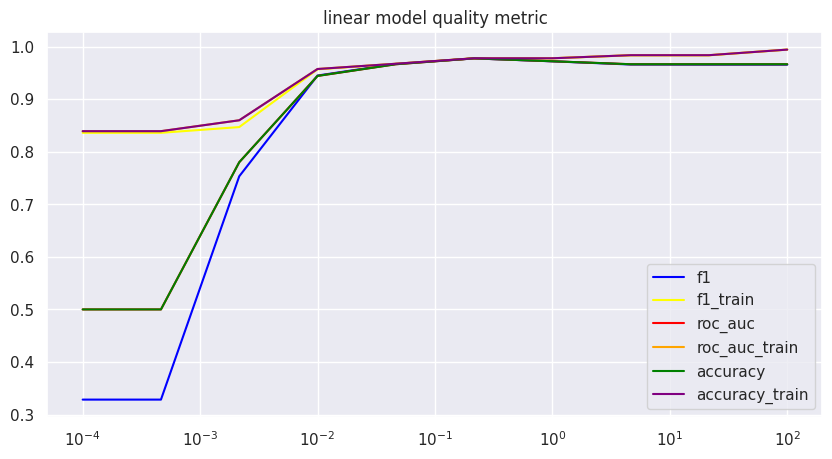

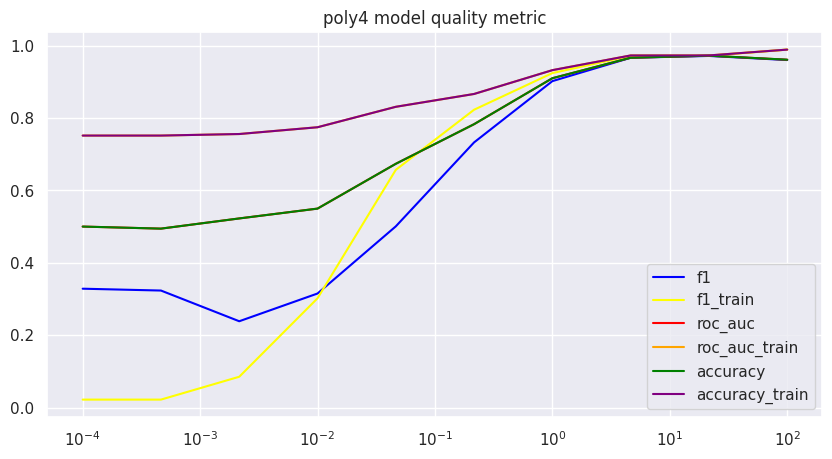

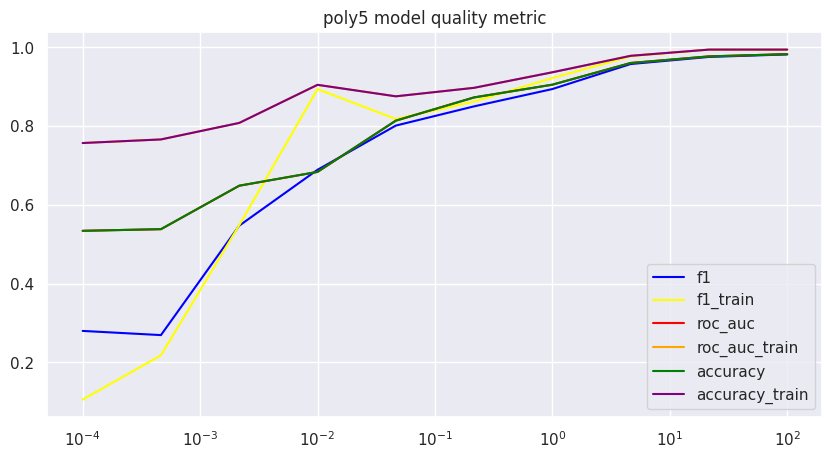

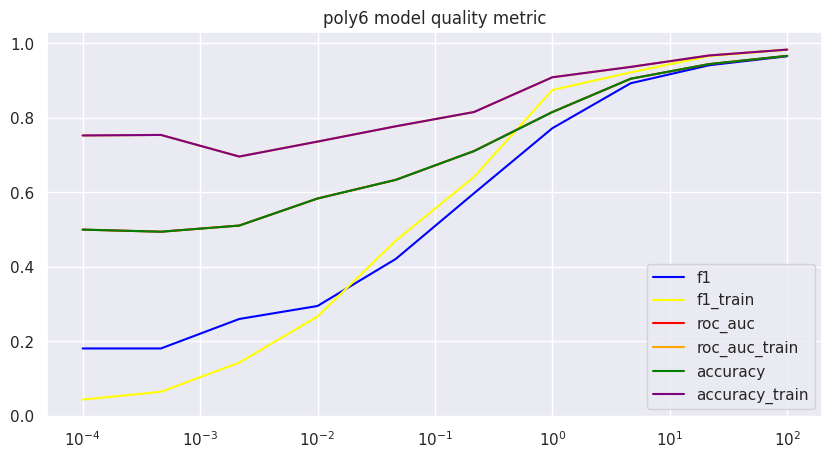

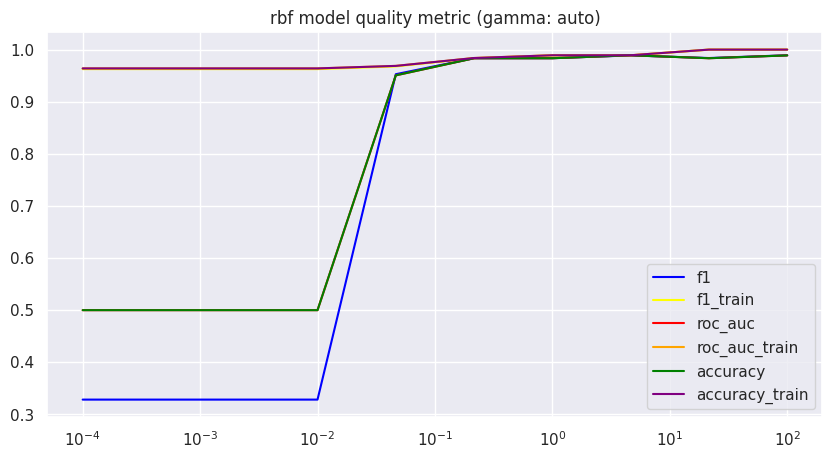

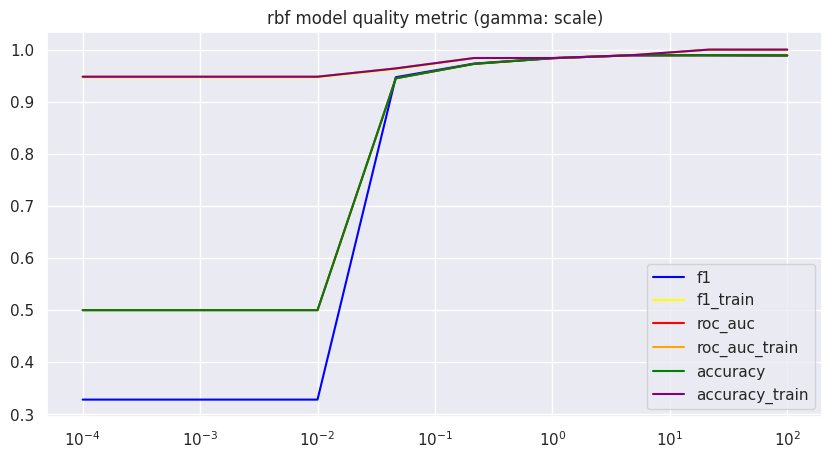

In [14]:
from sklearn.model_selection import cross_val_score

values = [{'kernel':'linear'}, {'kernel':'poly', 'degree':4}, {'kernel':'poly', 'degree':5}, {'kernel':'poly', 'degree':6}, {'kernel':'rbf', 'gamma':'auto'},\
          {'kernel':'rbf', 'gamma':'scale'}]
metrics = ['linear model quality metric', 'poly4 model quality metric', 'poly5 model quality metric', 'poly6 model quality metric',\
           'rbf model quality metric (gamma: auto)', 'rbf model quality metric (gamma: scale)']
for argues, name in zip(values, metrics):
    reg_cfs = np.logspace(-4, 2, 10)
    roc_auc_mean = []
    f1_mean = []
    accuracy_mean = []

    roc_auc_train_mean = []
    f1_train_mean = []
    accuracy_train_mean = []

    for reg_cf in reg_cfs:
        roc_auc_sum = 0
        f1_sum = 0
        accuracy_sum = 0

        roc_auc_train_sum = 0
        f1_train_sum = 0
        accuracy_train_sum = 0

        model = SVC(C=reg_cf, **argues)
        for i in range(6):
            roc_auc_sum += cross_val_score(model, X, y, cv=4, scoring=lambda e, X, y : roc_auc_score(y, e.predict(X))).mean()
            f1_sum += cross_val_score(model, X, y, cv=4, scoring=lambda e, X, y : f1_score(y, e.predict(X))).mean()
            accuracy_sum += cross_val_score(model, X, y, cv=4, scoring=lambda e, X, y : accuracy_score(y, e.predict(X))).mean()

            model.fit(X, y)

            roc_auc_train_sum += roc_auc_score(model.predict(X), y)
            f1_train_sum += f1_score(model.predict(X), y)
            accuracy_train_sum += accuracy_score(model.predict(X), y)

        roc_auc_mean.append(roc_auc_sum / 6)
        f1_mean.append(f1_sum / 6)
        accuracy_mean.append(accuracy_sum / 6)

        roc_auc_train_mean.append(roc_auc_train_sum / 6)
        f1_train_mean.append(f1_train_sum / 6)
        accuracy_train_mean.append(accuracy_train_sum / 6)

    plt.figure(figsize=(10, 5))
    plt.title(name)
    plt.xscale('log')
    plt.plot(reg_cfs, f1_mean, color='blue', label='f1')
    plt.plot(reg_cfs, f1_train_mean, color='yellow', label='f1_train')
    plt.plot(reg_cfs, roc_auc_mean, color='red', label='roc_auc')
    plt.plot(reg_cfs, roc_auc_train_mean, color='orange', label='roc_auc_train')
    plt.plot(reg_cfs, roc_auc_mean, color='green', label='accuracy')
    plt.plot(reg_cfs, roc_auc_train_mean, color='purple', label='accuracy_train')
    plt.legend()
    plt.show()

Выводы по новым графикам:

На данных графиках мы можем видеть результаты на нашей тестовой выборке. Благодаря этому можно смотреть насколько переобучилась наша модель

Параметр gamma почти ничего не оказывает влияние. Как видно, на последних двух графиках тут

В linear в какой-то момент переобучается как видно на наших графиках. Хотя в poly заметно, что чем выше ставится степень, тем больше параметр регуляризации C (считаем его optimal).


## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [15]:
import os
import re
import pathlib

from sklearn.utils import shuffle
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import ssl
# сделал костыль, ибо у меня не работало на моем маке
# оно само даст выбрать что скачать и после этого все заработало
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Пришлось прибегнуть к аткому костылю, поскольку на моей машинке не работало и не подключались все импорты и нужные библиотеки, поэтому сделали исключения обработку(решение-костыль взято со стаковерфлоу)

Выбрал своихэ 6 авторов

In [16]:
sent = []
#sel_authors = ['Bryusov', 'Chekhov']
sel_authors = ['Bryusov', 'Chekhov', 'Gogol', 'Gorky', 'Turgenev', 'Dostoevsky']
# sel_authors = ['Blok', 'Bryusov', 'Chekhov', 'Dostoevsky', 'Gogol', 'Herzen', 'Gorky', 'Tolstoy', 'Lermontov','Pushkin', 'Turgenev']
# так выбрад поскольку мне они защли
# закомментил то,  что не работало
# выдавало это ValueError: Cannot take a larger sample than population when 'replace=False'
# улалось разобратсьяб размерность неправильная чтоб их брать

In [17]:
os.chdir("/content/drive/My Drive/")
bas_dis = './data/prose/'

In [18]:
# считаем теперь все файлы и начнем формирование датасета
for sel_author in sel_authors:
    dtaset = os.listdir('./data/prose/{}'.format(sel_author))
    spltext = []
    for file in dtaset:
        if (re.match('.*\.txt', file)):
            filenew = open('./data/prose/{}'.format(sel_author) + '/' + file, 'r')
            spltext += nltk.tokenize.sent_tokenize(filenew.read())
    sendata = pd.DataFrame(spltext, columns=['sentence'])
    sendata.insert(1, 'author', sel_author)
    funci = lambda der: der.replace('\n', ' ')
    sendata['sentence'] = sendata['sentence'].apply(funci)
    sent.append(sendata)
display(*sent)

,sentence,author
0,Валерий Брюсов.,Bryusov
1,В башне Записа...,Bryusov
2,"Правда, я никогда не думал, что сон может бы...",Bryusov
3,Но все события этого сна стоят вне всякой свя...,Bryusov
4,"А чем иным отличается сон от яви, кроме т...",Bryusov
...,...,...
25385,"Чрез несколько дней после, я был с товарищами ...",Bryusov
25386,Она приняла нас с обычной приветливостью.,Bryusov
25387,Ни одним намеком не напомнила она мне об этой ...,Bryusov
25388,"Для меня, и до сих пор остается тайной, поняла...",Bryusov


,sentence,author
0,Дом с мезонином Рассказ художника I Это было...,Chekhov
1,"Он жил в саду во флигеле, а я в старом барском...",Chekhov
2,"Тут всегда, даже в тихую погоду, что-то гудело...",Chekhov
3,"Обреченный судьбой на постоянную праздность, я...",Chekhov
4,"По целым часам я смотрел в свои окна на небо, ...",Chekhov
...,...,...
25851,Но Алиса пришла и без письма.,Chekhov
25852,"Первую минуту она чувствовала себя неловко, но...",Chekhov
25853,"Переведены уже четыре книги, а Воротов не знае...",Chekhov
25854,1 до свиданья (франц.,Chekhov


,sentence,author
0,НОЧЬ ПЕРЕД РОЖДЕСТВОМ Последний день перед Рож...,Gogol
1,"Зимняя, ясная ночь наступила.",Gogol
2,Глянули звезды.,Gogol
3,Месяц величаво поднялся на небо посветить добр...,Gogol
4,"Морозило сильнее, чем с утра; но зато так было...",Gogol
...,...,...
26214,По правую руку его жена и дочь с устремившимся...,Gogol
26215,"По левую сторону городничего: Земляника, накло...",Gogol
26216,Прочие гости остаются просто столбами.,Gogol
26217,Почти полторы минуты окаменевшая группа сохран...,Gogol


,sentence,author
0,Максим Горький ДВАДЦАТЬ ШЕСТЬ И ОДНА ПОЭМА Нас...,Gorky
1,"Окна нашего подвала упирались в яму, вырытую п...",Gorky
2,"Наш хозяин забил окна железом для того, чтобы ...",Gorky
3,"Нам было тяжело и тошно в толстых стенах, разр...",Gorky
4,И целый день с утра до десяти часов вечера одн...,Gorky
...,...,...
53488,"Площадь пустеет; три светлые фигуры, взяв под ...",Gorky
53489,И снова вспоминается хорошая песня: «Христос в...,Gorky
53490,"1 Слава, мадонна, слава!",Gorky
53491,(Итал.,Gorky


,sentence,author
0,Иван Сергеевич Тургенев Отцы и дети Посвящае...,Turgenev
1,"– спрашивал 20 мая 1859 года, выходя без шапки...",Turgenev
2,"Слуга, в котором все: и бирюзовая сережка в ух...",Turgenev
3,– Не видать?,Turgenev
4,– повторил барин.,Turgenev
...,...,...
27449,Никто не умеет так верно и тонко подметить сме...,Turgenev
27450,"Муж Ирины быстро подвигается на том пути, кото...",Turgenev
27451,Тучный генерал обскакивает его; снисходительны...,Turgenev
27452,"И в том же городе, где проживает Ирина, прожив...",Turgenev


,sentence,author
0,Федор Достоевский.,Dostoevsky
1,Два самоубийства Недавно как-то мне случ...,Dostoevsky
2,"Я именно заметил ему перед этим, что я, чуть ...",Dostoevsky
3,"(Об Молчалине я еще когда-нибудь поговорю, т...",Dostoevsky
4,"- А знаете ли вы, - вдруг сказал мне мой собес...",Dostoevsky
...,...,...
120876,"Я смотрела на него, едва понимая то, что он мн...",Dostoevsky
120877,"-- После, извините меня, я нездорова, -- отвеч...",Dostoevsky
120878,"-- Итак, завтра, -- сказал он, откланиваясь, с...",Dostoevsky
120879,"Но, может быть, это мне так показалось.",Dostoevsky


Build your own dataset for these authors:
* divide each text into sentences such that we will have two columns:
    *sentence* and *target author*, each row will contain one sentence and one target
    
* drop sentences where N symbols in a sentence < 15
    
* fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    

In [19]:
func = lambda dertyr: dertyr[dertyr['sentence'].map(len) >= 15]
sent = list(map(func, sent))
# теперь одлжно быть все только то что боьше либо равно 15 символов по длине


display(*sent)

,sentence,author
0,Валерий Брюсов.,Bryusov
1,В башне Записа...,Bryusov
2,"Правда, я никогда не думал, что сон может бы...",Bryusov
3,Но все события этого сна стоят вне всякой свя...,Bryusov
4,"А чем иным отличается сон от яви, кроме т...",Bryusov
...,...,...
25384,"Я попросил передать мои извинения в том, что у...",Bryusov
25385,"Чрез несколько дней после, я был с товарищами ...",Bryusov
25386,Она приняла нас с обычной приветливостью.,Bryusov
25387,Ни одним намеком не напомнила она мне об этой ...,Bryusov


,sentence,author
0,Дом с мезонином Рассказ художника I Это было...,Chekhov
1,"Он жил в саду во флигеле, а я в старом барском...",Chekhov
2,"Тут всегда, даже в тихую погоду, что-то гудело...",Chekhov
3,"Обреченный судьбой на постоянную праздность, я...",Chekhov
4,"По целым часам я смотрел в свои окна на небо, ...",Chekhov
...,...,...
25850,Он решил узнать утром в адресном столе ее адре...,Chekhov
25851,Но Алиса пришла и без письма.,Chekhov
25852,"Первую минуту она чувствовала себя неловко, но...",Chekhov
25853,"Переведены уже четыре книги, а Воротов не знае...",Chekhov


,sentence,author
0,НОЧЬ ПЕРЕД РОЖДЕСТВОМ Последний день перед Рож...,Gogol
1,"Зимняя, ясная ночь наступила.",Gogol
2,Глянули звезды.,Gogol
3,Месяц величаво поднялся на небо посветить добр...,Gogol
4,"Морозило сильнее, чем с утра; но зато так было...",Gogol
...,...,...
26214,По правую руку его жена и дочь с устремившимся...,Gogol
26215,"По левую сторону городничего: Земляника, накло...",Gogol
26216,Прочие гости остаются просто столбами.,Gogol
26217,Почти полторы минуты окаменевшая группа сохран...,Gogol


,sentence,author
0,Максим Горький ДВАДЦАТЬ ШЕСТЬ И ОДНА ПОЭМА Нас...,Gorky
1,"Окна нашего подвала упирались в яму, вырытую п...",Gorky
2,"Наш хозяин забил окна железом для того, чтобы ...",Gorky
3,"Нам было тяжело и тошно в толстых стенах, разр...",Gorky
4,И целый день с утра до десяти часов вечера одн...,Gorky
...,...,...
53486,"Старухи — молятся: смотрят на эту троицу, прек...",Gorky
53487,"Это славный обычай — вовлекать птиц, чистейшее...",Gorky
53488,"Площадь пустеет; три светлые фигуры, взяв под ...",Gorky
53489,И снова вспоминается хорошая песня: «Христос в...,Gorky


,sentence,author
0,Иван Сергеевич Тургенев Отцы и дети Посвящае...,Turgenev
1,"– спрашивал 20 мая 1859 года, выходя без шапки...",Turgenev
2,"Слуга, в котором все: и бирюзовая сережка в ух...",Turgenev
4,– повторил барин.,Turgenev
5,"– Не видать, – вторично ответствовал слуга.",Turgenev
...,...,...
27448,И не одни молодые люди ее боятся; ее боятся и ...,Turgenev
27449,Никто не умеет так верно и тонко подметить сме...,Turgenev
27450,"Муж Ирины быстро подвигается на том пути, кото...",Turgenev
27451,Тучный генерал обскакивает его; снисходительны...,Turgenev


,sentence,author
0,Федор Достоевский.,Dostoevsky
1,Два самоубийства Недавно как-то мне случ...,Dostoevsky
2,"Я именно заметил ему перед этим, что я, чуть ...",Dostoevsky
3,"(Об Молчалине я еще когда-нибудь поговорю, т...",Dostoevsky
4,"- А знаете ли вы, - вдруг сказал мне мой собес...",Dostoevsky
...,...,...
120876,"Я смотрела на него, едва понимая то, что он мн...",Dostoevsky
120877,"-- После, извините меня, я нездорова, -- отвеч...",Dostoevsky
120878,"-- Итак, завтра, -- сказал он, откланиваясь, с...",Dostoevsky
120879,"Но, может быть, это мне так показалось.",Dostoevsky


In [20]:
# random state так же как и раньше делаем в 42 и отбираем рандомно
func_count = lambda data_find: data_find[0].sample(data_find[1], random_state=42)
# to concatenate pandas objects
dataset = pd.concat(map(func_count, zip(sent, [5000, 15000, 8000, 11000, 20000, 3000])))
# to modify an array or sequence in-place by shuffling its contents
dataset = shuffle(dataset)
# https://datagy.io/pandas-shuffle-dataframe/
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
dataset.reset_index(inplace=True, drop=True)
# все сделали что требуется
dataset

,sentence,author
0,"– Нехорошо, Петр Петрович, – говорила она укор...",Chekhov
1,"– Жаль-с, очень жаль, что не для рассуждений п...",Dostoevsky
2,"— сказала женщина, стоя у печи.",Gorky
3,"– Послушайте, Петр <Петрович>!",Gogol
4,"Ты в самом деле думаешь, что я в этом доме про...",Bryusov
...,...,...
61995,"Мать слушала его, и в груди ее дрожала гордост...",Gorky
61996,"Потом — Мокей, мордвин, Боев, Мишук, Сашок, — ...",Gorky
61997,"Это был красивый брюнет с выразительными, хотя...",Turgenev
61998,"Одни только идеи, а серьезного мало.",Chekhov


Preprocess (tokenize and clean) the dataset
* tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers

* convert to lower case and apply either stemming or lemmatization of the words (on your choice)

* vectorize words using both **bag of words** and **tf-idf** (use sklearn)

* observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [21]:
'''
теперь большой кооментарий
мне пришлось разделить наи разные ячйеки
поскольку просто не отрабатывает вместе из-за того  что мое ядро
взбесилось из-за того что я передаю list а не данные
плюс не отбражаются верхние данные с помощью  head
'''
dataset['sentence'] = dataset['sentence'].apply(nltk.word_tokenize)
dataset.head(8)

,sentence,author
0,"[–, Нехорошо, ,, Петр, Петрович, ,, –, говорил...",Chekhov
1,"[–, Жаль-с, ,, очень, жаль, ,, что, не, для, р...",Dostoevsky
2,"[—, сказала, женщина, ,, стоя, у, печи, .]",Gorky
3,"[–, Послушайте, ,, Петр, <, Петрович, >, !]",Gogol
4,"[Ты, в, самом, деле, думаешь, ,, что, я, в, эт...",Bryusov
5,"[В, воздухе, уже, не, так, сильно, пахло, ,, –...",Turgenev
6,"[Что, же, тут, невероятного, ?]",Dostoevsky
7,"[--, Все, это, враки, ,, Даша, ,, никаких, кол...",Bryusov


In [22]:
'''
теперь сделалил это remove all stop words (nltk.corpus.stopwords)
'''
ban_supervisor = nltk.corpus.stopwords.words('russian')
ban_supervisor1 = nltk.corpus.stopwords.words('english')
func_otbor = lambda spisok_slov: list(filter(lambda rab: rab not in ban_supervisor, spisok_slov))
dataset['sentence'] = dataset['sentence'].apply(func_otbor)
func_otbor1 = lambda spisok_slov: list(filter(lambda rab: rab not in ban_supervisor1, spisok_slov))
dataset['sentence'] = dataset['sentence'].apply(func_otbor1)
dataset.head(8)


,sentence,author
0,"[–, Нехорошо, ,, Петр, Петрович, ,, –, говорил...",Chekhov
1,"[–, Жаль-с, ,, очень, жаль, ,, рассуждений, пр...",Dostoevsky
2,"[—, сказала, женщина, ,, стоя, печи, .]",Gorky
3,"[–, Послушайте, ,, Петр, <, Петрович, >, !]",Gogol
4,"[Ты, самом, деле, думаешь, ,, доме, проведу, ж...",Bryusov
5,"[В, воздухе, сильно, пахло, ,, –, нем, снова, ...",Turgenev
6,"[Что, невероятного, ?]",Dostoevsky
7,"[--, Все, это, враки, ,, Даша, ,, никаких, кол...",Bryusov


In [23]:
'''
теперь это punctuation (string.punctuation)
'''
ban_punkt = string.punctuation
func_punkt = lambda spisok_slov : list(filter(lambda rab: rab not in ban_punkt, spisok_slov))
dataset['sentence'] = dataset['sentence'].apply(func_punkt)
dataset.head(8)

,sentence,author
0,"[–, Нехорошо, Петр, Петрович, –, говорила, уко...",Chekhov
1,"[–, Жаль-с, очень, жаль, рассуждений, приехали...",Dostoevsky
2,"[—, сказала, женщина, стоя, печи]",Gorky
3,"[–, Послушайте, Петр, Петрович]",Gogol
4,"[Ты, самом, деле, думаешь, доме, проведу, жизнь]",Bryusov
5,"[В, воздухе, сильно, пахло, –, нем, снова, раз...",Turgenev
6,"[Что, невероятного]",Dostoevsky
7,"[--, Все, это, враки, Даша, никаких, колдунов,...",Bryusov


In [24]:
'''
remove numbers тоже проделали
'''
ban_numbers = lambda x : re.search('\d+', x) is None
func_num = lambda spisok_slov : list(filter(ban_numbers, spisok_slov))
dataset['sentence'] = dataset['sentence'].apply(func_num)
dataset.head(8)

,sentence,author
0,"[–, Нехорошо, Петр, Петрович, –, говорила, уко...",Chekhov
1,"[–, Жаль-с, очень, жаль, рассуждений, приехали...",Dostoevsky
2,"[—, сказала, женщина, стоя, печи]",Gorky
3,"[–, Послушайте, Петр, Петрович]",Gogol
4,"[Ты, самом, деле, думаешь, доме, проведу, жизнь]",Bryusov
5,"[В, воздухе, сильно, пахло, –, нем, снова, раз...",Turgenev
6,"[Что, невероятного]",Dostoevsky
7,"[--, Все, это, враки, Даша, никаких, колдунов,...",Bryusov


convert to lower case and apply either stemming or lemmatization of the words (on your choice)

In [25]:
'''
теперь все к малому регистру приводим
'''

smaller_case_func = lambda slovo: slovo.lower()
func_small = lambda spisok_slov : list(map(smaller_case_func, spisok_slov))
dataset['sentence'] = dataset['sentence'].apply(func_small)
dataset.head(8)

,sentence,author
0,"[–, нехорошо, петр, петрович, –, говорила, уко...",Chekhov
1,"[–, жаль-с, очень, жаль, рассуждений, приехали...",Dostoevsky
2,"[—, сказала, женщина, стоя, печи]",Gorky
3,"[–, послушайте, петр, петрович]",Gogol
4,"[ты, самом, деле, думаешь, доме, проведу, жизнь]",Bryusov
5,"[в, воздухе, сильно, пахло, –, нем, снова, раз...",Turgenev
6,"[что, невероятного]",Dostoevsky
7,"[--, все, это, враки, даша, никаких, колдунов,...",Bryusov


In [26]:
from pymystem3 import Mystem

In [27]:
# взял стеммер из смеинара номер 6
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
stemmer_func = lambda slovo: stemmer.stem(slovo)
func_stem = lambda spisok_slov : list(map(stemmer_func, spisok_slov))
dataset['sentence'] = dataset['sentence'].apply(func_stem)
dataset.head(8)

,sentence,author
0,"[–, нехорош, петр, петрович, –, говор, укоризнен]",Chekhov
1,"[–, жаль-с, очен, жал, рассужден, приеха, очен...",Dostoevsky
2,"[—, сказа, женщин, сто, печ]",Gorky
3,"[–, послуша, петр, петрович]",Gogol
4,"[ты, сам, дел, дума, дом, провед, жизн]",Bryusov
5,"[в, воздух, сильн, пахл, –, нем, снов, разлива...",Turgenev
6,"[что, невероятн]",Dostoevsky
7,"[--, все, эт, врак, даш, никак, колдун, быва]",Bryusov


https://pypi.org/project/pymystem3/
сделаем лемитизацию

lematizing_func = lambda slovo: Mystem().lemmatize(slovo)[0]

func_lemi = lambda spisok_slov : list(map(lematizing_func, spisok_slov))

dataset['sentence'] = dataset['sentence'].apply(func_lemi)

dataset.head(8)

я пытался но оно не работает даже за 108 минут

In [28]:
func_joiner = lambda joiner: ' '.join(joiner)
tred_dataset = dataset['sentence'].apply(func_joiner)


In [30]:
# bag of words method

new_vector_mach = CountVectorizer(stop_words="english", dtype=np.int8)

vect_dataset = pd.DataFrame(new_vector_mach.fit_transform(tred_dataset).toarray(), columns=new_vector_mach.get_feature_names_out()).astype('int8')
vect_dataset['author'] = dataset['author']

# c 697 колонки идут русские слова

In [31]:
vect_dataset = vect_dataset.iloc[:, 697:]

vect_dataset

,parma,partie,parties,pas,passe,passons,pater,patres,patri,patrie,...,яшк,яшка,яшке,яшм,ящериц,ящик,ящичек,ящичк,ящур,author
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chekhov
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dostoevsky
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Gorky
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Gogol
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bryusov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Gorky
61996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Gorky
61997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Turgenev
61998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chekhov


In [29]:
# все те же саммыве действия но меняем векторную машину

new_vector_machina = TfidfVectorizer(stop_words="english", dtype=np.int8)

vect_dataset = pd.DataFrame(new_vector_machina.fit_transform(tred_dataset).toarray(), columns=new_vector_machina.get_feature_names_out()).astype('int8')
vect_dataset['author'] = dataset['author']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int8'> 'dtype' will be converted to np.float64.
  warnings.warn(


In [30]:
vect_dataset = vect_dataset.iloc[:, 697:]
vect_dataset

,parma,partie,parties,pas,passe,passons,pater,patres,patri,patrie,...,яшк,яшка,яшке,яшм,ящериц,ящик,ящичек,ящичк,ящур,author
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chekhov
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dostoevsky
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Gorky
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Gogol
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bryusov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Gorky
61996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Gorky
61997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Turgenev
61998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chekhov


В bag_w каждый элемент в i-й строке и j-м столбце представляет число teta, что означает количество слов с номером j в i-м предложении (слова нумеруются по алфавиту). В bag_tfidf у нас похожая ситуация, где 0 также обозначает то же самое. Но вместо количества слов в каждой ячейке таблицы мы имеем метрику, которая вычисляется как произведение доли слова в предложении на логарифм обратной доли документов, содержащих это слово. Идея здесь такова: чем чаще слово появляется в предложении, тем оно важнее, и чем чаще оно встречается в других документах, тем меньшую важность оно имеет.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [31]:
# your code here взял самых маленьких
auth_select_from_tfidf = vect_dataset[(vect_dataset.author == "Chekhov") | (vect_dataset.author == "Gogol")]


умная идея из чата


изначально происходила разбивка предложений на пропорции поэтому будет видно, что ничего одинаково не будет, но в качестве доказательства проведем исследования

In [32]:
words_mas = auth_select_from_tfidf.drop(columns='author')
words_otbor = words_mas.sum(axis=0)
words_right = words_otbor.sort_values()

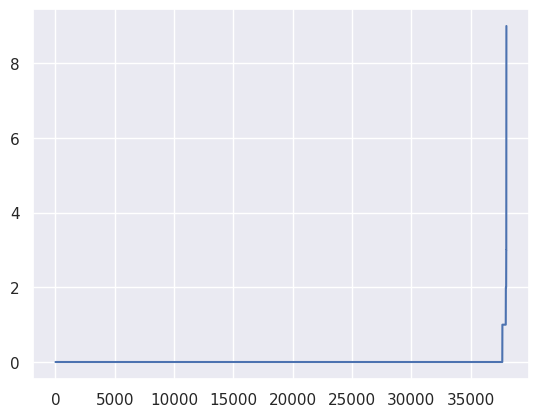

In [33]:
plt.plot(np.array(words_right[:-1]))

In [34]:
new_selection = words_right.loc[(words_right < 8) & (words_right > 2)]
# достаточно посмотреть без большой и маленькой метрик, у меня и так первая ячейка в этом здании обучается 200 лет
# нет, оно работает медленее я просто нерпавильно делал

<Axes: >

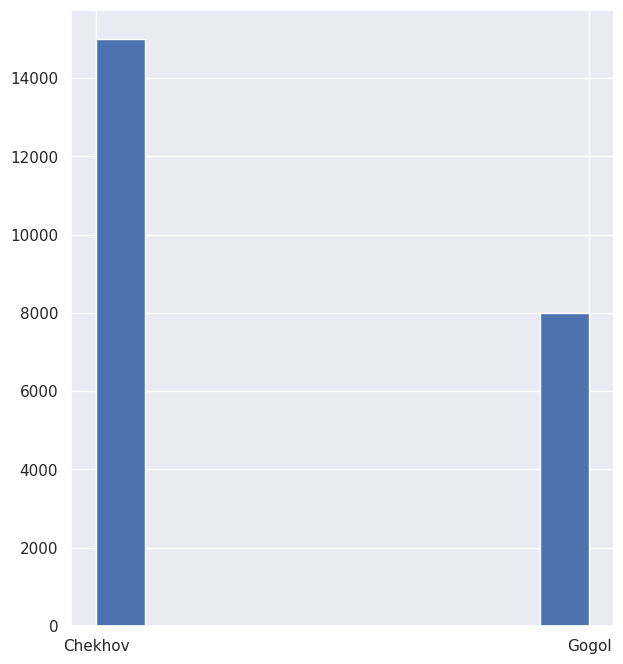

In [35]:
auth_select_from_tfidf['author'].hist(figsize=(7, 8))
# ну как видно, баланса тут нет, чтд и идем дальше

* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)

In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score

In [37]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics

scal = StandardScaler()
labenca = LabelEncoder()
# разбивку сделали теперь иреинрврока нужно сделать
dat_X = auth_select_from_tfidf[new_selection.index.to_list()]
duta_X = pd.DataFrame(scal.fit_transform(dat_X), columns=dat_X.columns.to_list())

dut_Y = labenca.fit_transform(auth_select_from_tfidf['author'])

# X_training, X_testing, y_training, y_testing = train_test_split(duta_X, dut_Y, test_size=0.3, random_state=42)


In [38]:
X_training, X_testing, y_training, y_testing = train_test_split(duta_X, dut_Y, test_size=0.3, random_state=42)

In [39]:
display(X_training, y_training)

,нич,любл,спрашива,прошепта,несчастн,жен,забормота,продолжа,вед,где,брав,что,знает,проговор,эт,хорош,как,дума,говор,бож
19520,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.013189,-0.013189,-0.013189,-0.013189,-0.014746,-0.014746,-0.014746,-0.016154,-0.016154
11323,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.013189,-0.013189,-0.013189,-0.013189,-0.014746,-0.014746,-0.014746,-0.016154,-0.016154
7019,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.013189,-0.013189,-0.013189,-0.013189,-0.014746,-0.014746,-0.014746,-0.016154,-0.016154
2216,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.013189,-0.013189,-0.013189,-0.013189,-0.014746,-0.014746,-0.014746,-0.016154,-0.016154
7500,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.013189,-0.013189,-0.013189,-0.013189,-0.014746,-0.014746,-0.014746,-0.016154,-0.016154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.013189,-0.013189,-0.013189,-0.013189,-0.014746,-0.014746,-0.014746,-0.016154,-0.016154
21575,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.013189,-0.013189,-0.013189,-0.013189,-0.014746,-0.014746,-0.014746,-0.016154,-0.016154
5390,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.013189,-0.013189,-0.013189,-0.013189,-0.014746,-0.014746,-0.014746,-0.016154,-0.016154
860,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.011422,-0.013189,-0.013189,-0.013189,-0.013189,-0.014746,-0.014746,-0.014746,-0.016154,-0.016154


array([0, 1, 0, ..., 0, 0, 1])

* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks

In [40]:
dertyu = np.logspace(-4, 2, 10)
dertyu
# лучше не пользоваться, уж слишком долго

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

In [46]:
from sklearn.model_selection import GridSearchCV

svc_model = SVC()

kernels = ['linear', 'rbf', 'poly']
# C_val = np.logspace(-4, 2, 10)
# создадим простйо массив а не логспейс
C_val = [0.01, 0.1, 1, 10, 100]
gamma_val = ['scale', 'auto']
classif = GridSearchCV(svc_model, {'kernel':kernels, 'C':C_val,\
                         'random_state':[42], 'gamma':gamma_val}, scoring='f1')
classif.fit(X_training, y_training)


display(classif.best_params_)
display(f1_score(classif.predict(X_testing), y_testing))
display(f1_score(classif.predict(X_training), y_training))
# работает получше, чем я думал

{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'random_state': 42}

0.0008254230293025175

0.0025040243248077264

In [47]:
import warnings
warnings.filterwarnings("ignore")
params = {'beta':[1e-4, 1e-3, 1e-2], 'gamma':[1e-2/2, 1e-2, 1e-2 * 2],\
          'max_iter':[1000], 'random_state':[42], 'lr':[0.5]}
classif_new = GridSearchCV(Logit(), param_grid=params, scoring='f1')

y_testing_cntr = y_testing
y_training_cntr = y_training
classif_new.fit(X_training, y_training_cntr)

display(classif_new.best_params_)
display(f1_score(classif_new.predict(X_training), y_training_cntr))
display(f1_score(classif_new.predict(X_testing), y_testing_cntr))
# главное ято работает

{'beta': 0.01, 'gamma': 0.01, 'lr': 0.5, 'max_iter': 1000, 'random_state': 42}

0.0035644270183567994

0.0016433853738701725

* make several plots to address the dependence between F1 score and parameters

gridseacrh

<Axes: xlabel='param_C', ylabel='mean_test_score'>

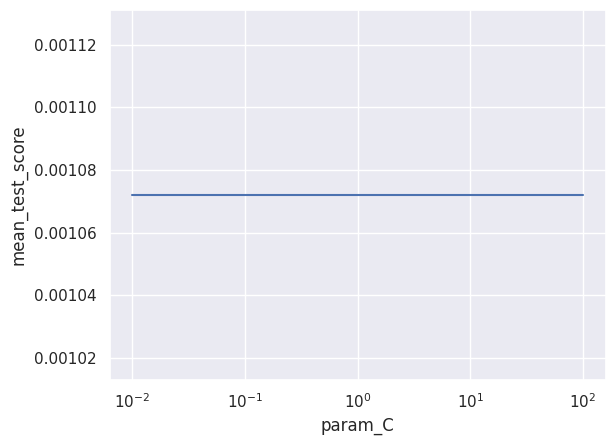

In [48]:
plt.xscale('log')
sns.lineplot(pd.DataFrame(classif.cv_results_).groupby('param_C')['mean_test_score'].max())
# сакмый лучший коэфф-т вышел 0.1 но в исследовании на графике не очень понятно почему не лбой другой

<BarContainer object of 3 artists>

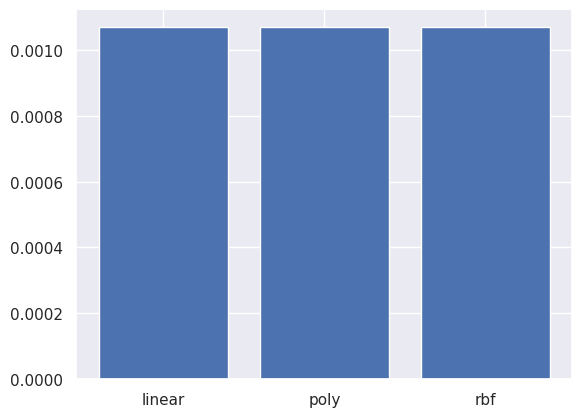

In [49]:
columns = pd.DataFrame(classif.cv_results_).groupby('param_kernel')['mean_test_score'].max()
plt.bar(columns.index, columns)
# все примперно одинаково

<BarContainer object of 2 artists>

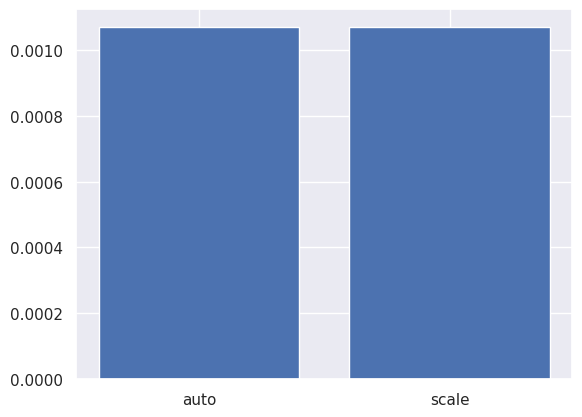

In [50]:
columns = pd.DataFrame(classif.cv_results_).groupby('param_gamma')['mean_test_score'].max()
plt.bar(columns.index, columns)
# gamma ни на что не влияет вообще

logit

<Axes: xlabel='param_beta', ylabel='mean_test_score'>

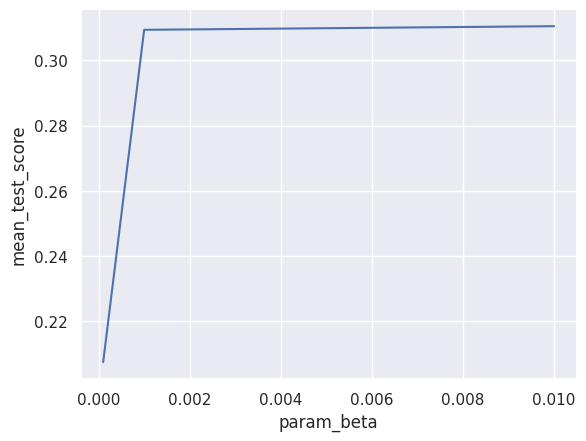

In [51]:
sns.lineplot(pd.DataFrame(classif_new.cv_results_).groupby('param_beta')['mean_test_score'].max())

<Axes: xlabel='param_gamma', ylabel='mean_test_score'>

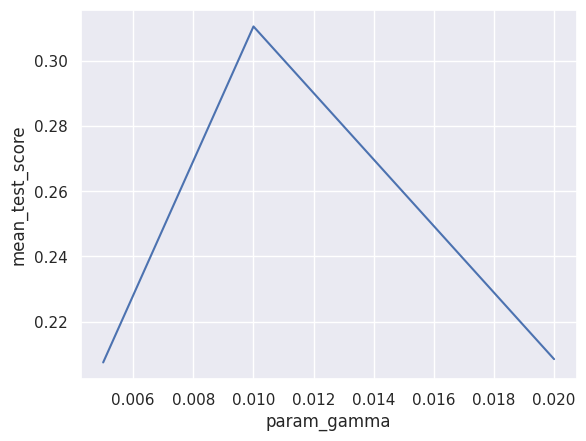

In [52]:
sns.lineplot(pd.DataFrame(classif_new.cv_results_).groupby('param_gamma')['mean_test_score'].max())

* plot confusion matrix for train and test samples

In [53]:
from sklearn.metrics import confusion_matrix

svc_training_mat = confusion_matrix(y_training, classif.predict(X_training))
svc_testing_mat = confusion_matrix(y_testing, classif.predict(X_testing))

logit_training_mat = confusion_matrix(y_training_cntr, classif_new.predict(X_training))
logit_testing_mat = confusion_matrix(y_testing_cntr, classif_new.predict(X_testing))

<Axes: >

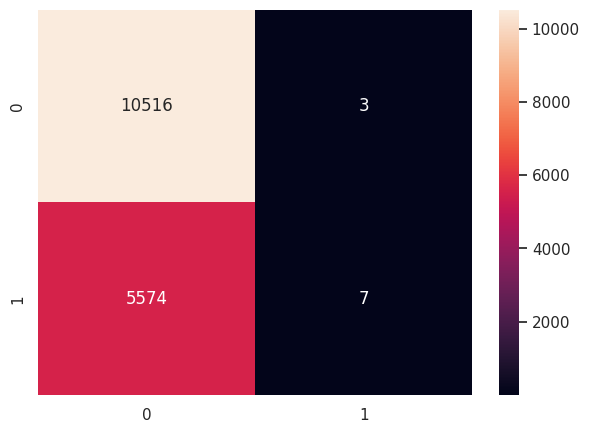

In [54]:
con_mat = pd.DataFrame(svc_training_mat)
plt.figure(figsize = (7,5))
sns.heatmap(con_mat, annot=True, fmt ='.10g')

<Axes: >

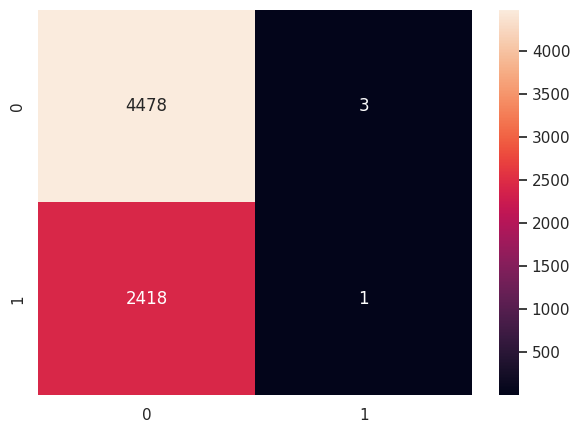

In [55]:
con_mat = pd.DataFrame(svc_testing_mat)
plt.figure(figsize = (7,5))
sns.heatmap(con_mat, annot=True, fmt ='.10g')

<Axes: >

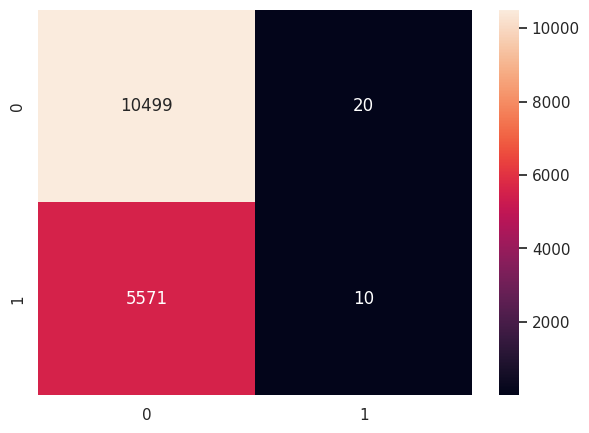

In [56]:
con_mat = pd.DataFrame(logit_training_mat)
plt.figure(figsize = (7,5))
sns.heatmap(con_mat, annot=True, fmt ='.10g')

<Axes: >

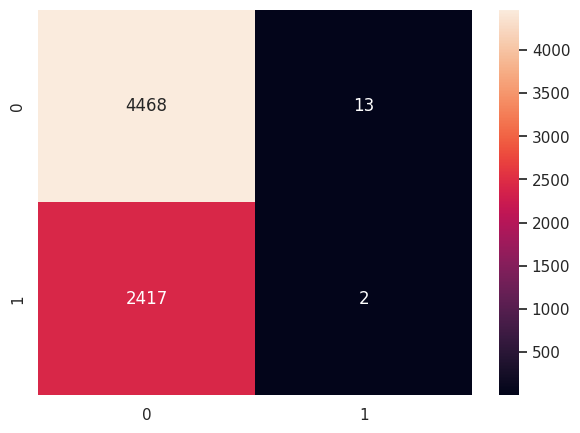

In [57]:
con_mat = pd.DataFrame(logit_testing_mat)
plt.figure(figsize = (7,5))
sns.heatmap(con_mat, annot=True, fmt ='.10g')

Результаты получились неоднозначными, но оно раблотоатет, я счастлив

Хоть иногда и очень долго

* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [59]:
print('precision')
display(precision_score(y_testing, classif.predict(X_testing)))
display(precision_score(y_testing_cntr, classif_new.predict(X_testing)))
print('f1')
display(f1_score(y_testing, classif.predict(X_testing)))
display(f1_score(y_testing_cntr, classif_new.predict(X_testing)))
print('accuracy')
display(accuracy_score(y_testing, classif.predict(X_testing)))
display(accuracy_score(y_testing_cntr, classif_new.predict(X_testing)))
print('recall')
display(recall_score(y_testing, classif.predict(X_testing)))
display(recall_score(y_testing_cntr, classif_new.predict(X_testing)))

precision


0.25

0.13333333333333333

f1


0.0008254230293025175

0.0016433853738701725

accuracy


0.6491304347826087

0.6478260869565218

recall


0.00041339396444811904

0.0008267879288962381

Относительно данных исследований получалось примерно одинаковое, но потом заметно стало различие в некотррых метриках, из чего возможен вывод что это дает примерное равенство

Как по мне, имхо методы векторизации получились не очень, поскольку не используем больше никакой инфы помимо мн-ва слов.

Долго обучение связано с гигантскими размерами векторов слов/значений

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [43]:
from sklearn.metrics import roc_curve


In [44]:
from sklearn.metrics import RocCurveDisplay

<Axes: >

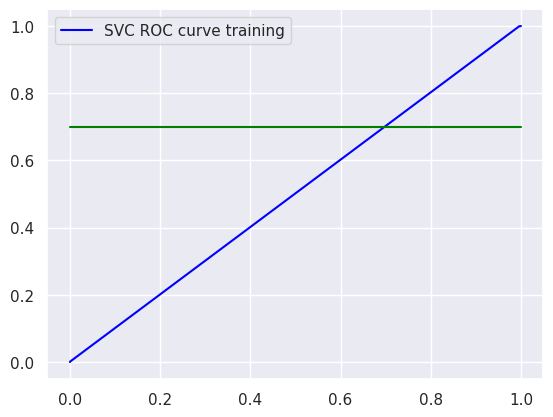

In [60]:
# your code here

workmodel = SVC(**classif.best_params_, probability=True)
workmodel.fit(X_training, y_training)

fpwork, tswork, treshold = roc_curve(y_training, workmodel.predict_proba(X_training).transpose()[1])
plt.plot(fpwork, tswork, color='blue', label='SVC ROC curve training')
sns.lineplot(x=[0, 1], y=[0.7, 0.7], color='green')

<Axes: >

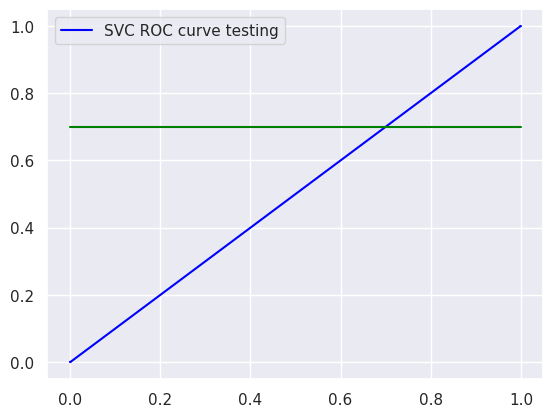

In [61]:
fpwork, tswork, treshold = roc_curve(y_testing, workmodel.predict_proba(X_testing).transpose()[1])
plt.plot(fpwork, tswork, color='blue', label='SVC ROC curve testing')
sns.lineplot(x=[0, 1], y=[0.7, 0.7], color='green')

1.0

<Axes: >

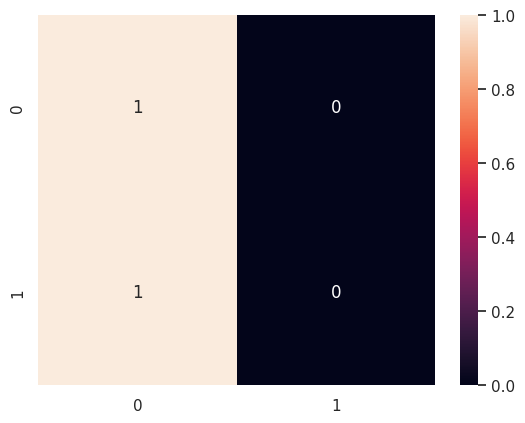

In [75]:
treshold_tuta = 0
for treshold_iter, fpr_iter in zip(treshold, fpwork):
    if fpr_iter > 0.27:
        break
    treshold_tuta = treshold_iter

display(treshold_tuta)

dfer = workmodel.predict_proba(X_testing).transpose()

fred = confusion_matrix(y_testing, dfer[1] > treshold_tuta, normalize='true')
sns.heatmap(fred, annot=True, fmt='.2g')

<Axes: >

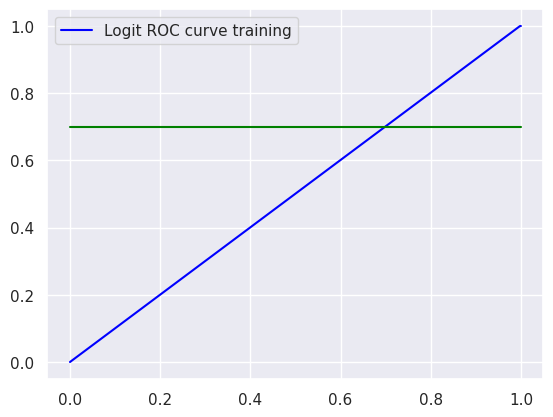

In [76]:
fret = classif_new.predict_proba(X_training)[1]
fpwork, tswork, treshold = roc_curve(y_training_cntr, fret)
plt.plot(fpwork, tswork, color='blue', label='Logit ROC curve training')
sns.lineplot(x=[0, 1], y=[0.7, 0.7], color='green')

<Axes: >

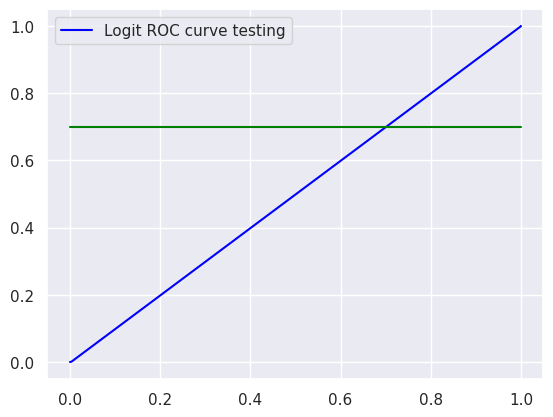

In [78]:
tyreu = classif_new.predict_proba(X_testing)[1]
fpwork, tswork, treshold = roc_curve(y_testing_cntr, tyreu)
plt.plot(fpwork, tswork, color='blue', label='Logit ROC curve testing')
sns.lineplot(x=[0, 1], y=[0.7, 0.7], color='green')

0.12755297743877672

<Axes: >

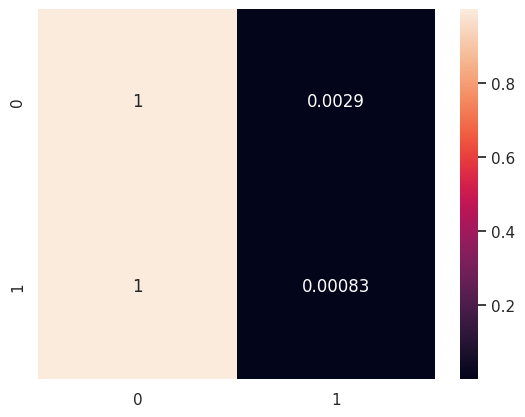

In [84]:
treshold_tuta = 0
for treshold_iter, fpr_iter in zip(treshold, fpwork):
    if fpr_iter > 0.27:
        break
    treshold_tuta = treshold_iter

display(treshold_tuta)

sns.heatmap(confusion_matrix(y_testing, classif_new.predict_proba(X_testing)[1] > treshold_tuta,\
            normalize='true'), annot=True, fmt='.2g')

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [85]:
# your code here
from sklearn.multiclass import OneVsOneClassifier
import sklearn.metrics

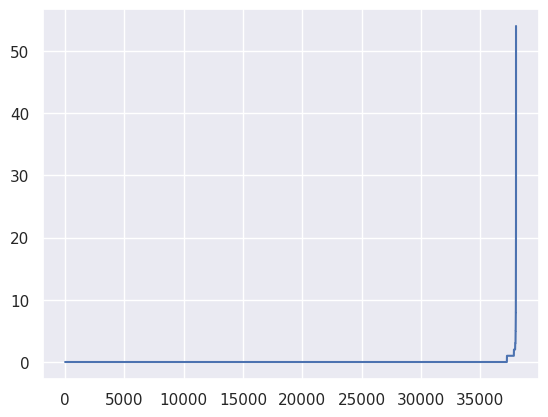

In [86]:
words_mas = vect_dataset.drop(columns='author')
words_otbor = words_mas.sum(axis=0)
words_right = words_otbor.sort_values()
plt.plot(np.array(words_right))
words_right = words_right[8500:-50]

<Axes: >

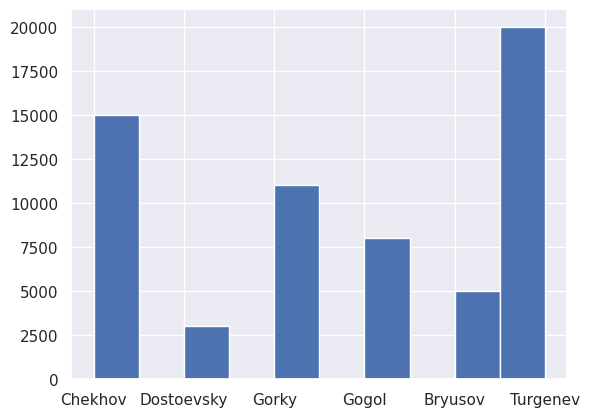

In [87]:
vect_dataset['author'].hist()

<Axes: >

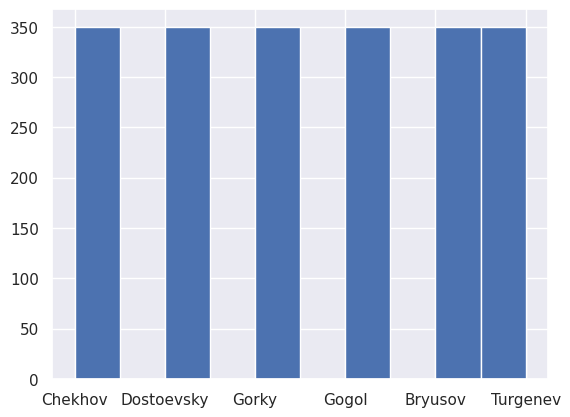

In [88]:
sele_tion = []
ost = 350
for auth in vect_dataset['author'].unique():
  sele_tion.append(vect_dataset[vect_dataset['author'] == auth].sample(ost))
new_dataset_sel = pd.concat(sele_tion)
new_dataset_sel['author'].hist()

In [89]:
labenca = LabelEncoder()
X_new_sel_dta = new_dataset_sel[words_right.index]
y_new_sel_dta = new_dataset_sel['author']
y_new_sel = labenca.fit_transform(y_new_sel_dta)


In [90]:
display(X_new_sel_dta, y_new_sel)

,перестанут,переспрос,переспрашива,переспел,пересказа,пересказыв,пересказыва,перескакива,перескоч,перескочить,...,любл,мал,посмотр,кто,засмея,франц,простона,город,наход,узна
12110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56764,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


array([1, 1, 1, ..., 5, 5, 5])

In [91]:
X_trainin, X_testin, y_trainin, y_testin = train_test_split(X_new_sel_dta, y_new_sel, test_size=0.3, random_state=42)

In [92]:
display(X_trainin, y_trainin)

,перестанут,переспрос,переспрашива,переспел,пересказа,пересказыв,пересказыва,перескакива,перескоч,перескочить,...,любл,мал,посмотр,кто,засмея,франц,простона,город,наход,узна
56774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49819,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51626,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51519,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


array([4, 1, 3, ..., 3, 3, 4])

работает больше чем 110 минут

In [93]:
paras = {
    'estimator__C': [0.5, 1, 1.5, 2],
    'estimator__kernel': ["linear","rbf"],
    'estimator__random_state' : [42]
}

classi = OneVsOneClassifier(SVC())
gswork = GridSearchCV(classi, paras)

gswork.fit(X_trainin, y_trainin)
display(gswork.best_params_)

{'estimator__C': 0.5,
 'estimator__kernel': 'rbf',
 'estimator__random_state': 42}

<Axes: >

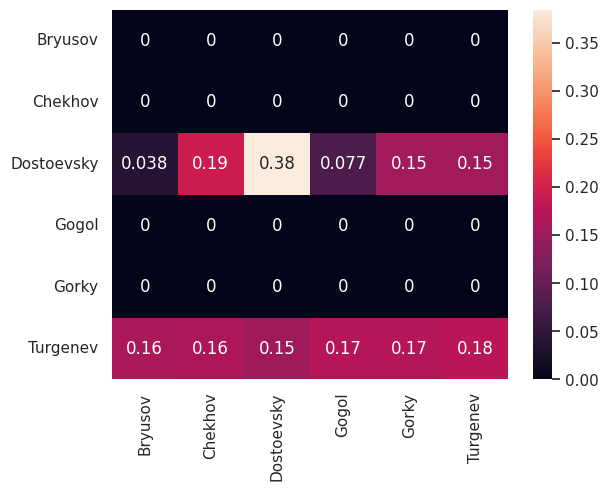

In [94]:
sns.heatmap(confusion_matrix(gswork.predict(X_trainin), y_trainin, normalize='true'),\
            annot=True, fmt='.2g', xticklabels=labenca.classes_, yticklabels=labenca.classes_)

творится полный капец все катится непонятно куда и не работает нормально как нужно

<Axes: >

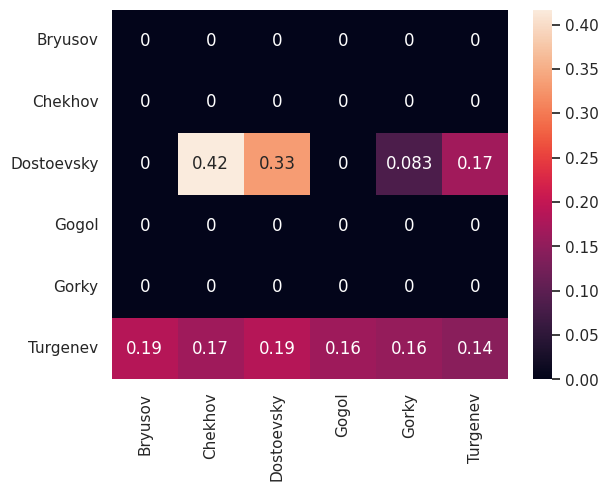

In [95]:
sns.heatmap(confusion_matrix(gswork.predict(X_testin), y_testin, normalize='true'),\
            annot=True, fmt='.2g', xticklabels=labenca.classes_, yticklabels=labenca.classes_)

капец, становится еще хуже, качество падает в некоторых местах, но в некоторых стало лучше, что меня очень поразило, видимо срезы зря делал там сверху и из-за этого такие резы, но перезапускать все это смерть

дня не хватит чтобы это отработало снова, но при проверке можно цбрать срезы и я уверен что отработает

но сейчас без них ОЗУ колаба и ОЗУ мака моего норм не хватит, чтоб я смог заново обработать без них и не умереть

сейчас задействовано было 12.2/12.7 гб

In [96]:
predi = gswork.predict(X_testin)
display(accuracy_score(predi, y_testin))
display(precision_score(predi, y_testin, average=None))
display(precision_score(predi, y_testin, average='macro'))
display(precision_score(predi, y_testin, average='micro'))
display(recall_score(predi, y_testin, average=None))
display(recall_score(predi, y_testin, average='macro'))
display(recall_score(predi, y_testin, average='micro'))

0.14761904761904762

array([0.        , 0.        , 0.03361345, 0.        , 0.        ,
       0.97802198])

0.16860590390002153

0.14761904761904762

array([0.        , 0.        , 0.33333333, 0.        , 0.        ,
       0.14401294])

0.07955771305285868

0.14761904761904762